# Project 15: Novel Analysis

##### This project aims to investigate the structure and stylistic properties of a Novel book The Master Builder by Henrik Ibsen | Project Gutenberg available in Gutenberg resource, focusing on the dialogue part between the different characters. The text contains character’s name followed by a short description of the state of character (text under square bracket) followed by the text stated by the given character. Sometimes, in the text stated by the given character, there is a mention of another character, to point to the fact that the discussion is mainly targeting the mentioned character.

Packages

In [56]:
import nltk
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt

Preparations

In [73]:
# Load in the book
file = open('the_master_builder.txt', mode='r', encoding='utf-8')
book = file.read()
file.close()

# Characters and aliases
characters = [
    'SOLNESS.',
    'MRS. SOLNESS.',
    'DR. HERDAL.',
    'BROVIK.',
    'RAGNAR.',
    'KAIA.',
    'HILDA.'
]
aliases = {
    'SOLNESS.' : [
        'Halvard', 
        'Halvard Solness', 
        'Mr. Solness', 
        'Master Builder',
        'Master Builder Solness'
    ],
    'MRS. SOLNESS.' : [
        'Aline', 
        'Mrs. Solness'
    ],
    'DR. HERDAL.' : [
        'Dr. Herdal',
        'Doctor Herdal'
    ],
    'BROVIK.' : [
        'Knut Brovik'
    ],
    'RAGNAR.' : [
        'Ragnar',
        'Ragnar Brovik'
    ],
    'KAIA.' : [
        'Kaia', 
        'Kaia Fosli', 
        'Miss Fosli'
    ],
    'HILDA.' : [
        'Hilda',
        'Miss Hilda', 
        'Miss Wangel'
    ]
}
print('Characters and aliases:')
for character in characters:
    print(f'\t{character}')
    for alias in aliases[character]:
        print(f'\t\t{alias}')

# Split book into paragrahs
paragraphs = book.split('\n\n\n')

# Clean up paragraphs
for i, paragraph in enumerate(paragraphs):
    paragraphs[i] = paragraph.replace('\n', ' ')
#print(paragraphs)

Characters and aliases:
	SOLNESS.
		Halvard
		Halvard Solness
		Mr. Solness
		Master Builder
		Master Builder Solness
	MRS. SOLNESS.
		Aline
		Mrs. Solness
	DR. HERDAL.
		Dr. Herdal
		Doctor Herdal
	BROVIK.
		Knut Brovik
	RAGNAR.
		Ragnar
		Ragnar Brovik
	KAIA.
		Kaia
		Kaia Fosli
		Miss Fosli
	HILDA.
		Hilda
		Miss Hilda
		Miss Wangel


1. First, by utilizing all textbook as input, we want to elucidate the importance of individual characters. For
this purpose, suggest a script that records the number of occurrences of each character in the whole
textbook. Next, we assume the importance of the characters is indicated by the number of citations each
character is receiving in the text statement. Summarize the result in a table indicating the importance of
the characters according to i) frequency of occurrence of characters, ii) citations count of the characters.


In [74]:
# Occurances and citations
occurances = dict()
citations = dict()
for paragraph in paragraphs:
    for character in characters:
        if paragraph.find(character) == 0:
            occurances[character] = occurances.get(character, 0) + 1

            for character in characters:
                for alias in aliases[character]:
                    if alias in paragraph:
                        citations[character] = citations.get(character, 0) + 1
                        continue

#print(occurances)
#print(citations)

# Sort by occurance count
sorted_occurances = sorted(occurances.items(), key=lambda item: item[1], reverse=True)

data = {
    'Character' : [],
    'Occurances' : [],
    'Citations' : []
}

for pair in sorted_occurances:
    character = pair[0]
    occurance_count = pair[1]
    citation_count = citations[character]
    
    data['Character'].append(character)
    data['Occurances'].append(occurance_count)
    data['Citations'].append(citation_count)

importance = pd.DataFrame(data)
print(importance)

       Character  Occurances  Citations
0       SOLNESS.         655         83
1         HILDA.         519        102
2  MRS. SOLNESS.         141         51
3    DR. HERDAL.          94          3
4        RAGNAR.          70         38
5          KAIA.          48         36
6        BROVIK.          41          2


2. Suggest a script that gathers the text associated with each character, excluding the short text under
square bracket concerning the state of the target, as a single dataframe, and then, elucidates each
dataframe by identifying its vocabulary set, vocabulary size, total number of tokens, total number of
adjectives, total number of adverbs, total number of verbs, total number of nouns. Summarize in a table
the above main statistical characteristics.


In [75]:
from nltk.stem import WordNetLemmatizer
# nltk.download('averaged_perceptron_tagger_eng')
wnl = WordNetLemmatizer()

# PoS Tags
ADJ_tags = ['JJ', 'JJR', 'JJS']
ADV_tags = ['RB', 'RBR', 'RBS']
VERB_tags = ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']
NOUN_tags = ['NN', 'NNS', 'NNP', 'NNPS']

# Initialize Dataframes
dataframes = dict()
for character in characters:
    dataframes[character] = {
        'paragraphs' : list(),
        'tokens' : list(),
        'vocabulary' : dict(),
        'ADJ' : 0,
        'ADV' : 0,
        'VERB' : 0,
        'NOUN' : 0,
        'PoS_tags' : list()
    }

def remove_square_brackets(paragraph, character):
    new_paragraph = ''
    last_bracket = ''
    saveChar = True

    # Cut character name
    paragraph = paragraph[len(character):]

    # Ignore chars inside brackets, Save chars outside brackets
    for char in paragraph:
        if char == '[':
            last_bracket = char
            saveChar = False
        elif char == ']':
            last_bracket = char
            saveChar = True
        
        elif saveChar:
            new_paragraph = new_paragraph + char
            
    return new_paragraph

for paragraph in paragraphs:
    for character in characters:
        if paragraph.find(character) == 0:
            
            # Save paragraph
            dataframes[character]['paragraphs'].append(paragraph)
            
            # Remove square bracket contents from paragraph
            paragraph = remove_square_brackets(paragraph, character)

            # Tokenize, lemmatize, get vocabulary size
            tokens = nltk.tokenize.word_tokenize(paragraph)
            dataframes[character]['tokens'].extend(tokens)
            for token in tokens:
                if re.search('[a-zA-Z]', token):
                    lem_token = wnl.lemmatize(token.lower())
                    new_value = dataframes[character]['vocabulary'].get(lem_token, 0) + 1
                    dataframes[character]['vocabulary'][lem_token] = new_value

            # PoS Tagging
            pos_tagged = nltk.pos_tag(tokens)
            
            for pos_tag in pos_tagged:
                tag = pos_tag[1]
                
                # Save for Task 8
                dataframes[character]['PoS_tags'].append(tag)
                
                if tag in ADJ_tags:
                    dataframes[character]['ADJ'] += 1
                elif tag in ADV_tags:
                    dataframes[character]['ADV'] += 1
                elif tag in VERB_tags:
                    dataframes[character]['VERB'] += 1
                elif tag in NOUN_tags:
                    dataframes[character]['NOUN'] += 1
            
            continue

print(pd.DataFrame(dataframes))

                                                     SOLNESS.  \
paragraphs  [SOLNESS.  [Near the door, points towards the ...   
tokens      [Are, they, gone, What, is, that, you, are, en...   
vocabulary  {'are': 44, 'they': 43, 'gone': 5, 'what': 80,...   
ADJ                                                       494   
ADV                                                       891   
VERB                                                     1755   
NOUN                                                     1393   
PoS_tags    [NNP, PRP, VBN, WP, VBZ, IN, PRP, VBP, VBG, ,,...   

                                                MRS. SOLNESS.  \
paragraphs  [MRS. SOLNESS.  [In the doorway.] Halvard!, MR...   
tokens      [Halvard, !, I, am, afraid, I, am, disturbing,...   
vocabulary  {'halvard': 27, 'i': 80, 'am': 7, 'afraid': 3,...   
ADJ                                                       100   
ADV                                                       222   
VERB                    

3. Write a script that draws the evolution of the vocabulary size with respect to the number of tokens for
each dataframe, and then study the fitting of the Heap’s law and its statistical significance in terms of Rsquared and adjusted R-squared statistics (see Project 1 for possible pointers). Comment on the
talkativity of each character.


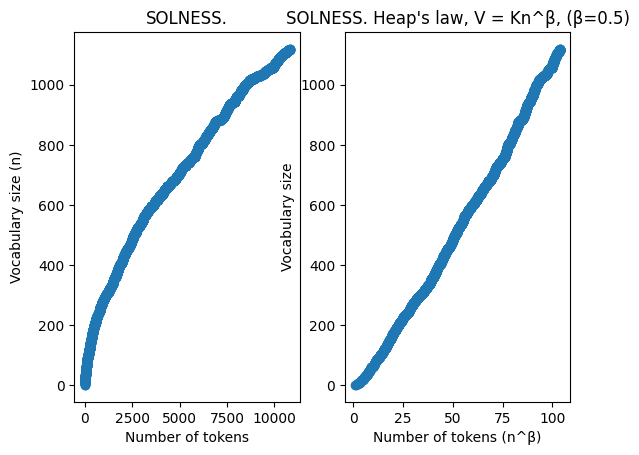

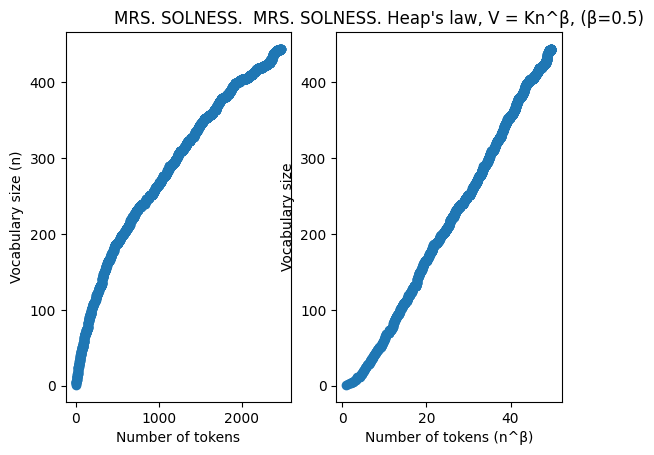

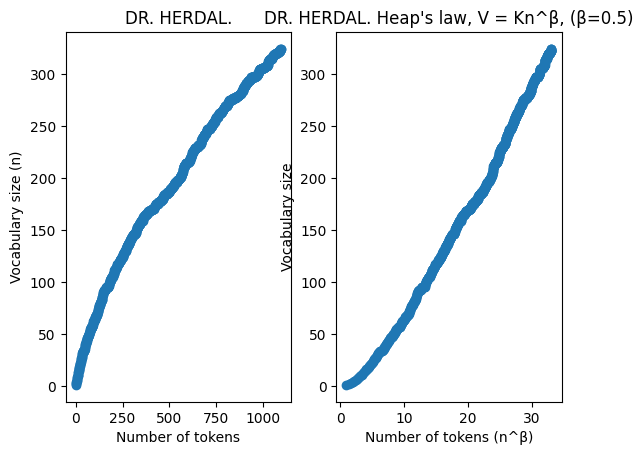

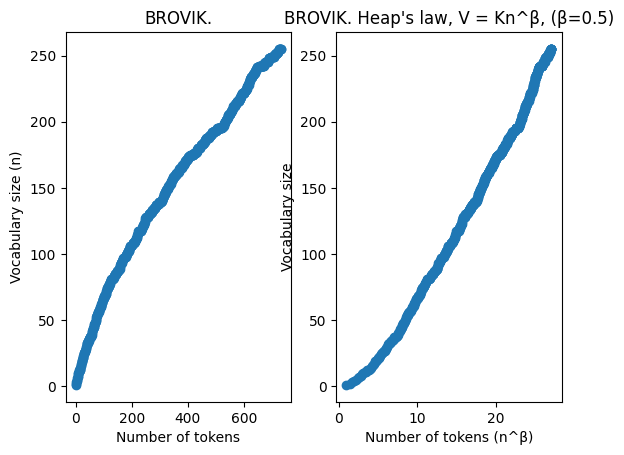

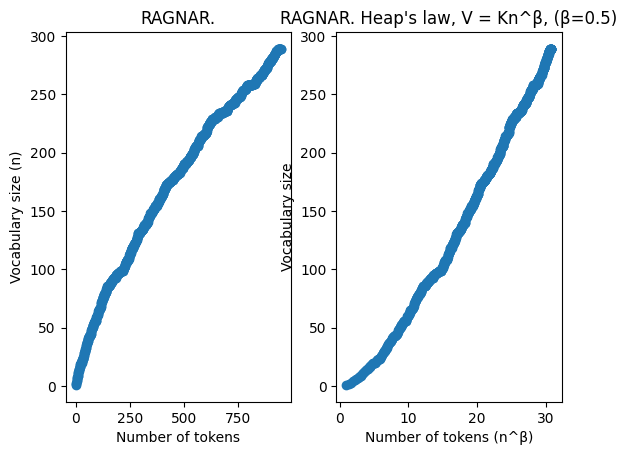

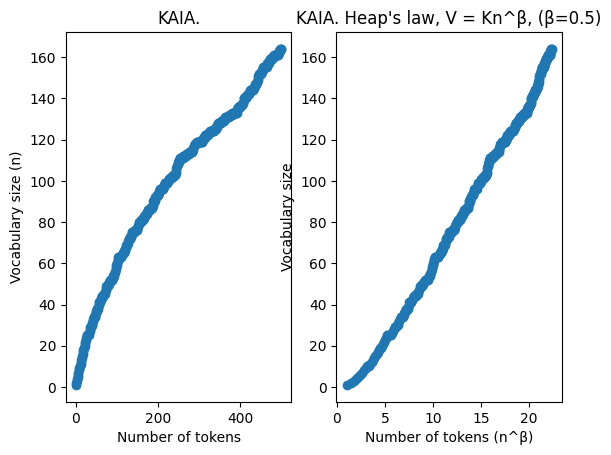

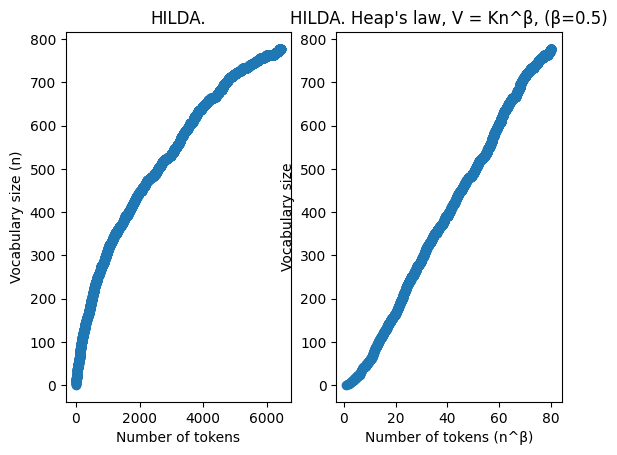

In [76]:
for character in characters:

    number_of_tokens = list()
    cumulative_vocabulary_size = list()
    vocabulary = dict()
    unique_tokens = 0

    for count, token in enumerate(dataframes[character]['tokens']):
        number_of_tokens.append(count + 1)
        
        lem_token = wnl.lemmatize(token.lower())
        new_value = vocabulary.get(lem_token, 0)
        if new_value == 0:
            unique_tokens += 1
        vocabulary[lem_token] = new_value + 1

        cumulative_vocabulary_size.append(unique_tokens)

    # Plots
    x = number_of_tokens
    y = cumulative_vocabulary_size
    plt.subplot(1, 2, 1)
    plt.scatter(x, y)
    plt.title(character)
    plt.xlabel('Number of tokens')
    plt.ylabel('Vocabulary size (n)')

    # Heap's law
    beta = 0.5
    x = np.power(number_of_tokens, beta)
    y = np.power(cumulative_vocabulary_size, 1)
    plt.subplot(1, 2, 2)
    plt.scatter(x, y)
    plt.title(f'{character} Heap\'s law, V = Kn^β, (β={beta})')
    plt.xlabel('Number of tokens (n^β)')
    plt.ylabel('Vocabulary size')

    plt.show()

4. Consider the modal verbs (can, may, must, shall, will, could, might, should, would), write a script that
tracks the occurrence of modal verbs in each dataframe, then plot a graph showing the evolution of the
number of modal verbs employed with respect to the number of tokens, and then study the possible
fitting of a polynomial interpolation cure, indicating the 90% confidence curve as well (see pointers in
Project 1). Comment on the difference between the usage of modal verbs by each character.


c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=7.64748e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=7.24902e-31): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=7.01961e-39): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


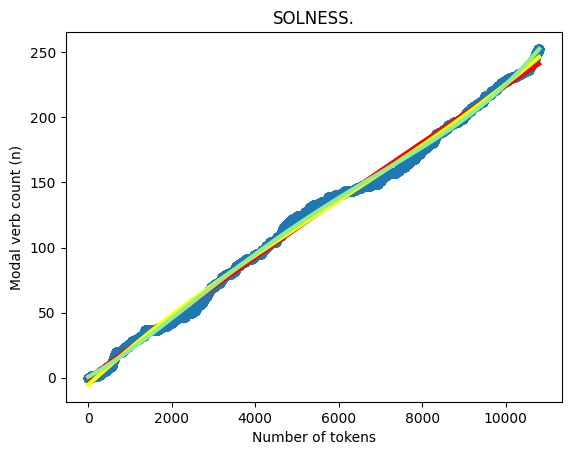

c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.21735e-19): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.20246e-26): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=4.07099e-33): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


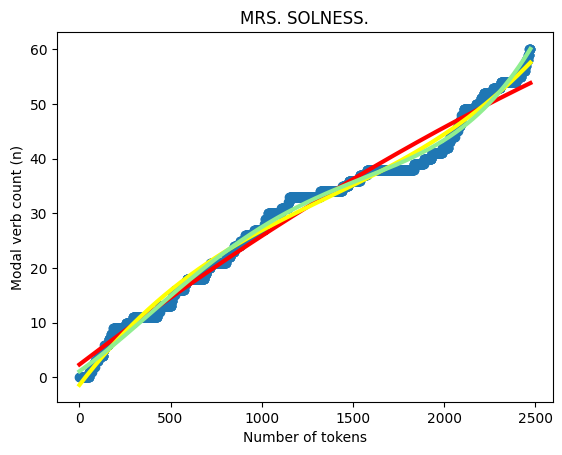

c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=7.09556e-18): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.52618e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=6.1331e-30): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


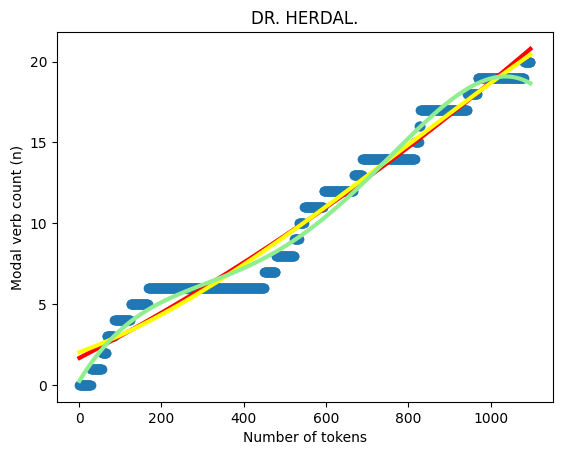

c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=5.3325e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.09885e-22): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.31387e-28): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


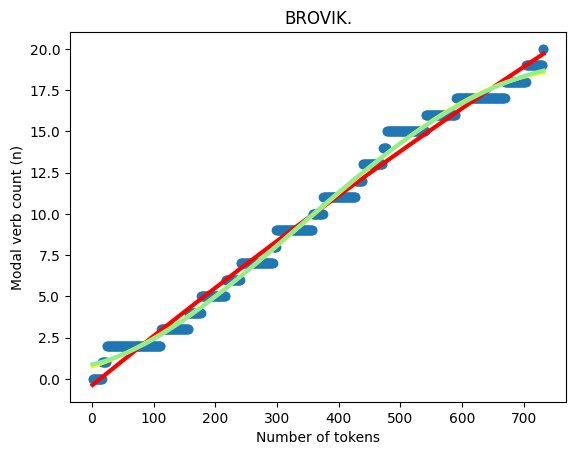

c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.46495e-17): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.80061e-23): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.26138e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


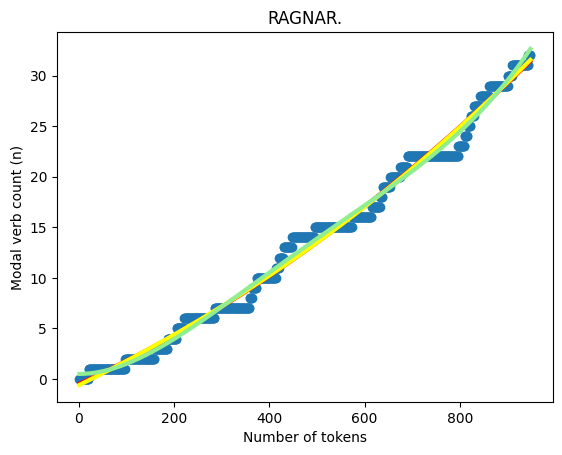

c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.60202e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=7.25399e-27): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


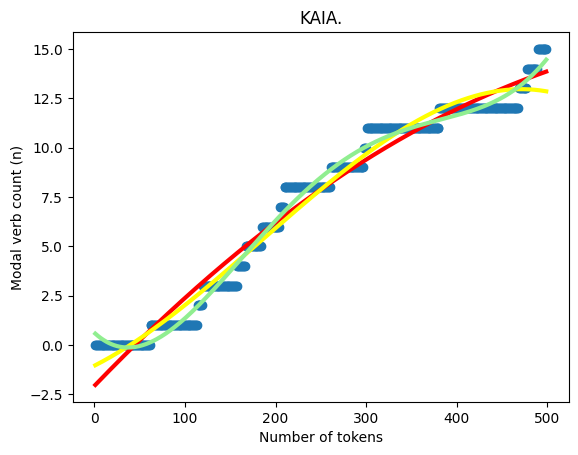

c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=1.01911e-21): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=2.7218e-29): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T
c:\Users\Juuso\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_ridge.py:213: LinAlgWarning: Ill-conditioned matrix (rcond=7.42625e-37): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


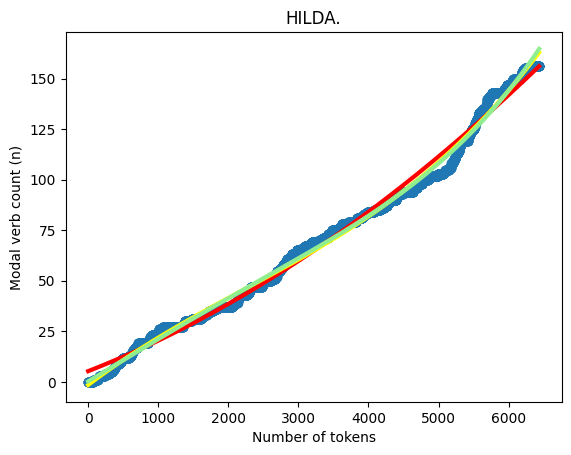

In [77]:
# pip install scikit-learn
import sklearn

MODAL_VERBS = ['can', 'may', 'must', 'shall', 'will', 'could', 'might', 'should', 'would']

for character in characters:

    number_of_tokens = list()
    cumulative_modal_verb_count = list()
    modal_verb_count = 0

    for count, token in enumerate(dataframes[character]['tokens']):
        number_of_tokens.append(count + 1)

        if token.lower() in MODAL_VERBS:
            modal_verb_count += 1

        cumulative_modal_verb_count.append(modal_verb_count)

    # Plots
    fig, ax = plt.subplots()
    x = number_of_tokens
    y = cumulative_modal_verb_count
    ax.scatter(x, y)
    plt.title(character)
    plt.xlabel('Number of tokens')
    plt.ylabel('Modal verb count (n)')

# Polynomial interpolation
#https://scikit-learn.org/stable/auto_examples/linear_model/plot_polynomial_interpolation.html
    ax.set_prop_cycle(
        color=["red", "yellow", "lightgreen"]
    )
    x = np.array(x)
    y = np.array(y)
    x = x[:, np.newaxis]
    y = y[:, np.newaxis]
    for degree in range(2, 5):
        model = sklearn.pipeline.make_pipeline(sklearn.preprocessing.PolynomialFeatures(degree), sklearn.linear_model.Ridge(alpha=1e-3))
        model.fit(x, y)
        y_plot = model.predict(x)
        plt.plot(x, y_plot, linewidth=3)
    plt.show()

5. Suggest a script that identifies the five most frequent tokens, excluding the stopwords and uncommon
characters in the whole textbook, then, estimate the frequency of occurrence each of these words in each
dataframe of an individual character, yielding a five dimension vector for each character. Calculate the
similarity of each pair of characters using cosine similarity of the corresponding vectors. Summarize the
result in a table.


In [78]:
from nltk.corpus import stopwords
english_stopwords = stopwords.words('english')
#print(english_stopwords)

# Top 5 most frequent tokens
total_vocabulary = dict()
for character in characters:
    for word in dataframes[character]['tokens']:
        word = word.lower()
        # Get words (tokens that are not: stopwords, punctuation marks or incomplete like: n't, 's)
        if word not in english_stopwords and re.search('[a-zA-Z]', word) and '\'' not in word:
            total_vocabulary[word] = total_vocabulary.get(word, 0) + 1

sorted_words = sorted(total_vocabulary.items(), key=lambda item: item[1], reverse=True)
top5 = sorted_words[:5]
print(f'Top 5 most frequent tokens: {top5}')

# Frequency of top5 most frequent tokens per character
for character in characters:
    vector = list()
    for word in top5:
        frequency = dataframes[character]['vocabulary'].get(word[0], 0)

        vector.append(frequency)
    dataframes[character]['top5vector'] = vector

# Normalized cosine similarity between all characters

column_names = list()
for name in characters:
    column_names.append(name[:-1])

size = len(characters)
similarity_matrix = np.zeros((size, size))

def norm_cosine_similarity(first_items, second_items):
    dividend = np.dot(first_items, second_items)
    divisor = np.linalg.norm(first_items) * np.linalg.norm(second_items)
    norm_cosine_sim = dividend / divisor
    return norm_cosine_sim

for i, character1 in enumerate(characters):
    for j, character2 in enumerate(characters):
        vector1 = dataframes[character1]['top5vector']
        vector2 = dataframes[character2]['top5vector']
        norm_cosine_sim = norm_cosine_similarity(vector1, vector2)
        similarity_matrix[i][j] = round(norm_cosine_sim, 3)

#print(similarity_matrix)
matrix_df = pd.DataFrame(similarity_matrix, index=column_names, columns=column_names)
print(matrix_df)

Top 5 most frequent tokens: [('yes', 261), ('oh', 154), ('well', 129), ('one', 104), ('must', 95)]
              SOLNESS  MRS. SOLNESS  DR. HERDAL  BROVIK  RAGNAR   KAIA  HILDA
SOLNESS         1.000         0.951       0.966   0.796   0.984  0.882  0.988
MRS. SOLNESS    0.951         1.000       0.885   0.736   0.937  0.978  0.968
DR. HERDAL      0.966         0.885       1.000   0.808   0.969  0.800  0.950
BROVIK          0.796         0.736       0.808   1.000   0.813  0.654  0.719
RAGNAR          0.984         0.937       0.969   0.813   1.000  0.890  0.964
KAIA            0.882         0.978       0.800   0.654   0.890  1.000  0.910
HILDA           0.988         0.968       0.950   0.719   0.964  0.910  1.000


6. Suggest a script that generates embedding vector for each dataframe, using for instance, doc2vec
embedding, and then compare the similarity between the characters in terms of the corresponding cosine
similarity score between the corresponding embedding vectors. Summarize the result in a table.


In [79]:
# doc2vec embedding for each character?

# normalized cosine similarity between all characters' doc2vec vectors (similarly as in 5)

7. Repeat 6) when empath category-based embedding https://github.com/Ejhfast/empath-client is
employed. Summarize the result in a matrix and comment on the results.


In [81]:
# pip install empath


# Install package before running ^
from empath import Empath
lexicon = Empath()

for character in characters:
    analysis = lexicon.analyze(dataframes[character]['paragraphs'], normalize=True)
    dataframes[character]['empath'] = analysis    

# Normalized cosine similarity between all characters
similarity_matrix = np.zeros((size, size))

for i, character1 in enumerate(characters):
    for j, character2 in enumerate(characters):
        vector1 = list(dataframes[character1]['empath'].values())
        vector2 = list(dataframes[character2]['empath'].values())
        norm_cosine_sim = norm_cosine_similarity(vector1, vector2)
        similarity_matrix[i][j] = round(norm_cosine_sim, 3)

#print(similarity_matrix)
matrix_df = pd.DataFrame(similarity_matrix, index=column_names, columns=column_names)
print(matrix_df)

              SOLNESS  MRS. SOLNESS  DR. HERDAL  BROVIK  RAGNAR   KAIA  HILDA
SOLNESS         1.000         0.920       0.841   0.772   0.816  0.748  0.930
MRS. SOLNESS    0.920         1.000       0.845   0.737   0.798  0.753  0.883
DR. HERDAL      0.841         0.845       1.000   0.690   0.727  0.706  0.877
BROVIK          0.772         0.737       0.690   1.000   0.632  0.642  0.730
RAGNAR          0.816         0.798       0.727   0.632   1.000  0.724  0.778
KAIA            0.748         0.753       0.706   0.642   0.724  1.000  0.759
HILDA           0.930         0.883       0.877   0.730   0.778  0.759  1.000


8. Use the NLTK parser to identify the PoS tags of each token in each dataframe and displays a histogram
showing the frequency of each tag in the dataframe. Next, use the dispersion plot, see examples in
https://www.scikit-yb.org/en/latest/api/text/dispersion.html, to show the dispersion of dominant PoS tag
with respect to word offset.


In [ ]:
# pip install yellowbrick
# Yellowbrick requires python version < 3.12, so I couldn't get it to work
import yellowbrick
from yellowbrick.text import DispersionPlot

for character in characters:
    tag_frequencies = dict()
    PoS_tags = dataframes[character]['PoS_tags']
    
    for tag in PoS_tags:
        tag_frequencies[tag] = tag_frequencies.get(tag, 0) + 1

    sorted_tags = sorted(tag_frequencies.items(), key=lambda item: item[1], reverse=True)
    #print(sorted_tags)
    tags, frequencies = zip(*sorted_tags)

    # Histogram
    plt.bar(tags, frequencies)
    plt.title(f'{character} PoS-tag frequencies')
    plt.xlabel('Frequency')
    plt.xticks(rotation=90)
    plt.ylabel('Tag')
    plt.show()

    # Dispersion plot
    

9. Now we want to track individual messages by each character. For this purpose, suggest a script that uses
sentiWordNet lexicon GitHub - aesuli/SentiWordNet: The SentiWordNet sentiment lexicon, where each
token is assigned a positive and negative score, if no lexicon is found, it is neutral, to determine the
sentiment of each character message by summing up and averaging overall sentiment scores across all
the lexicon terms. Then represents each character’s message as a point in a triangle-based illustration
with nodes corresponding to positive, negative and neutral. Trace the plot corresponding to each
character.


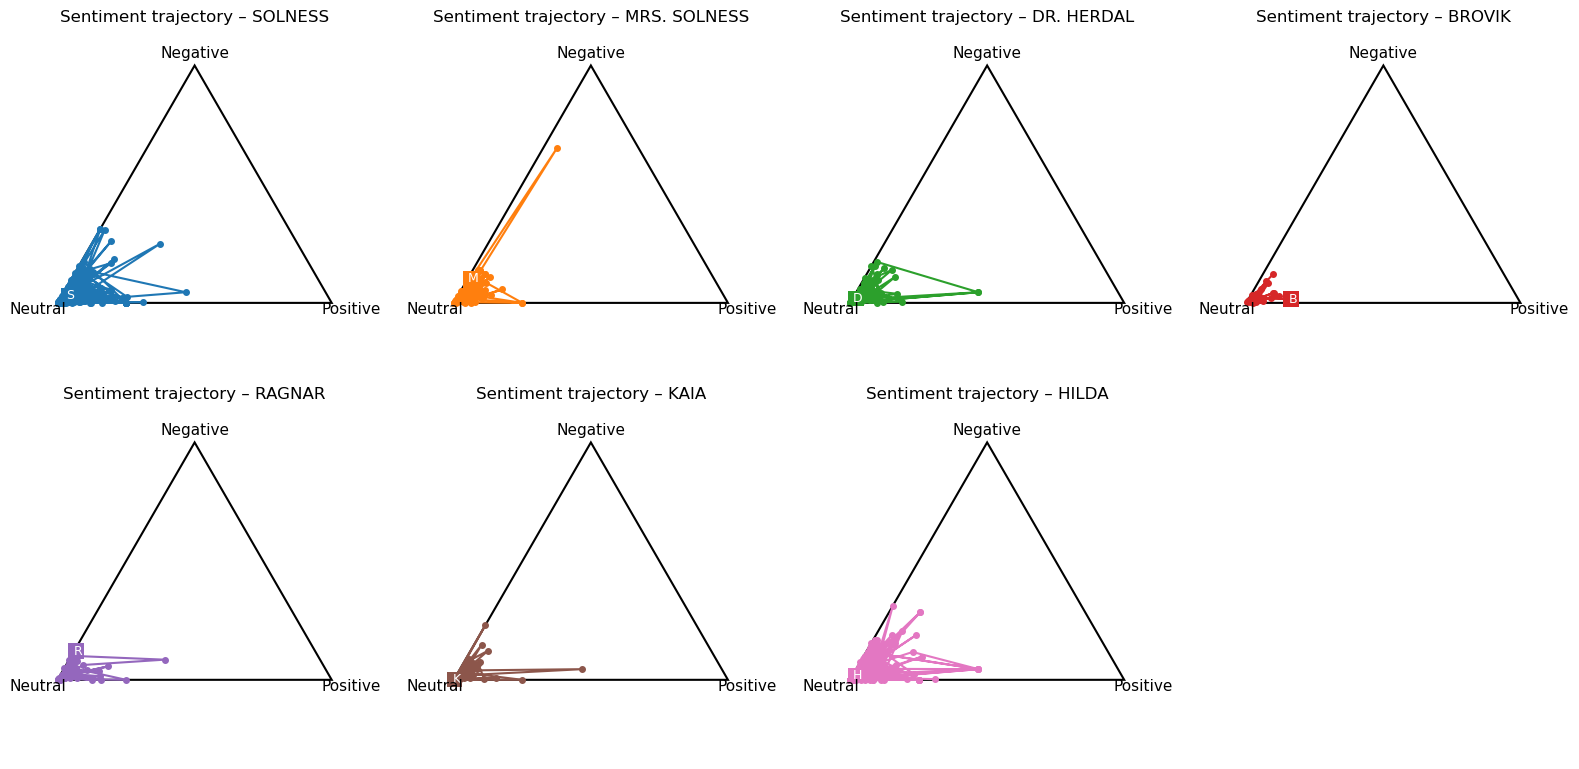

In [58]:
from nltk.corpus import sentiwordnet as swn, wordnet as wn
from nltk import pos_tag, word_tokenize

#nltk.download('sentiwordnet', quiet=True)
#nltk.download('wordnet', quiet=True)
#nltk.download('averaged_perceptron_tagger', quiet=True)
#nltk.download('punkt', quiet=True)

from matplotlib.patches import Polygon

def wn_pos(tag):
    if tag.startswith('J'):   return wn.ADJ
    if tag.startswith('V'):   return wn.VERB
    if tag.startswith('N'):   return wn.NOUN
    if tag.startswith('R'):   return wn.ADV
    return None

# Sentiment of a single word avg of synsets
def word_sentiment(word, pos):
    wnpos = wn_pos(pos)
    if not wnpos:                     # no mapping → neutral
        return 0.0, 0.0, 1.0
    synsets = list(swn.senti_synsets(word, wnpos))
    if not synsets:                   # not in SentiWordNet → neutral
        return 0.0, 0.0, 1.0
    pos = sum(s.pos_score() for s in synsets) / len(synsets)
    neg = sum(s.neg_score() for s in synsets) / len(synsets)
    neu = sum(s.obj_score() for s in synsets) / len(synsets)
    return pos, neg, neu

# Extract individual spoken messages
messages = {c: [] for c in characters}

for para in paragraphs:
    for c in characters:
        if para.startswith(c):
            txt = re.sub(r'\[.*?\]', '', para)      # drop [stage directions]
            txt = txt.replace(c, '', 1).strip()     # drop speaker name
            if txt:
                messages[c].append(txt)
            break

# Calculate (pos, neg, neu) averages per message
sentiments = {c: [] for c in characters}

for c in characters:
    for msg in messages[c]:
        tokens = word_tokenize(msg.lower())
        tagged = pos_tag(tokens)

        pos_sum = neg_sum = neu_sum = 0.0
        cnt = 0

        for word, tag in zip(tokens, [t[1] for t in tagged]):
            if word.isalpha():
                p, n, o = word_sentiment(word, tag)
                pos_sum += p
                neg_sum += n
                neu_sum += o
                cnt += 1

        if cnt:
            sentiments[c].append((pos_sum/cnt, neg_sum/cnt, neu_sum/cnt))
        else:
            sentiments[c].append((1/3, 1/3, 1/3))

# Triangle plot
def triangle_plot(ax, points, char_name, color='C0'):
    if not points:
        ax.text(0.5, 0.5, 'No data', ha='center', va='center')
        return

    pos = np.array([p for p, n, neu in points])
    neg = np.array([n for p, n, neu in points])
    neu = np.array([neu for p, n, neu in points])

    # Normalise just in case rounding errors appear
    total = pos + neg + neu
    pos = pos / total
    neg = neg / total
    neu = neu / total

    X = 0.5 * (2*pos + neg)
    Y = (np.sqrt(3)/2) * neg

    ax.plot(X, Y, marker='o', markersize=4, color=color, label=char_name)

    # Mark the last point with the character’s initial
    ax.text(X[-1], Y[-1], f' {char_name[0]}', fontsize=9,
            ha='center', va='center', color='white',
            bbox=dict(facecolor=color, edgecolor='none', pad=1))

    # Triangle outline
    triangle = np.array([[0, 0], [1, 0], [0.5, np.sqrt(3)/2]])
    ax.add_patch(Polygon(triangle, closed=True, fill=False,
                         edgecolor='k', linewidth=1.5))

    # Corner labels
    ax.text(-0.07, -0.04, 'Neutral', fontsize=11, ha='center')
    ax.text(1.07, -0.04, 'Positive', fontsize=11, ha='center')
    ax.text(0.5, np.sqrt(3)/2 + 0.03, 'Negative', fontsize=11, ha='center')

    ax.set_xlim(-0.15, 1.15)
    ax.set_ylim(-0.1, 0.95)
    ax.set_aspect('equal')
    ax.axis('off')
    ax.set_title(f'Sentiment trajectory – {char_name[:-1]}', pad=15)

# Plot one subplot per person
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()
colors = plt.cm.tab10.colors

for idx, c in enumerate(characters):
    triangle_plot(axes[idx], sentiments[c], c, color=colors[idx % len(colors)])

# Hide the empty 8th subplot bc only have 7
axes[-1].axis('off')

plt.tight_layout()
plt.show()


10. Now we want to focus on those messages where the square bracket text contains an emoiji like text,
e.g., smiling, after a manual scrutinizing of the text, draw a list of messages together with their
associated emojis. We want to quantify the extent of which the text matches the corresponding emoji.
For this purpose, study the MIT DeepMoji project https://github.com/huggingface/torchMoji where for
a given textual post, an automatically generated emoji is outputted, and generate emoji for each of the
conversation message in the list and study the matching between the two corresponding emojis.


11. Use appropriate literature to comment on the findings. Also, identify any additional input that would
allow you to further elucidate any of the preceding, and use appropriate literature of corpus linguistic
literature to justify your findings and comment on the obtained results. Finally, comment on the
limitations and structural weakness of the data processing pipeline. 